# Satellite Boat Clustering Pipeline

This notebook automates the extraction, embedding, clustering, and interactive visualization of boats from high-resolution satellite imagery.

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules from the src directory
from src import _0_Chips as chips
from src import _1_Embedding as embedding
from src import _2_Clustering as clustering
from src import _3_Visualization as visualization
from src import _4_Interactive_Map_Context as interactive

# Global Configuration
RAW_DIR = "./data/raw"
EXTRACTED_DIR = "./data/extracted"
RESULTS_DIR = "./results"

# Ensure directories exist
os.makedirs(EXTRACTED_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Suppress TensorFlow logging for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2026-02-17 14:58:50.095106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 14:58:50.124925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 14:58:50.817544: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Step 0: Data Extraction (Chips)

This step processes the raw `.tif` and `.geojson` pairs. It extracts a strict bounding box for each boat and applies **black padding** to create a square `224x224` image, preserving the boat's original aspect ratio.

In [2]:
import pandas as pd
import os
import glob

# Ensure your path variables are correctly defined
RAW_DIR = "./data/raw"
EXTRACTED_DIR = "./data/extracted"
CACHE_PATH = os.path.join(EXTRACTED_DIR, "metadata_cache.csv")

# --- CRITICAL FIX: Create the directory if it's missing ---
if not os.path.exists(EXTRACTED_DIR):
    os.makedirs(EXTRACTED_DIR, exist_ok=True)
    print(f"[Info] Created missing directory: {EXTRACTED_DIR}")

tiffs = glob.glob(os.path.join(RAW_DIR, "*.tif"))
all_meta = []
run_extraction = True

# --- CACHE LOGIC ---
if os.path.exists(CACHE_PATH):
    print(f"[Info] Found metadata cache at {CACHE_PATH}")
    df_metadata = pd.read_csv(CACHE_PATH)
    
    # Check if .npy files actually exist
    if not df_metadata.empty and os.path.exists(df_metadata.iloc[0]['chip_path']):
        print(f"       Loaded {len(df_metadata)} samples from cache. Skipping extraction.")
        run_extraction = False
    else:
        print("       [Warning] Cache exists but .npy files are missing. Re-extracting...")

# --- EXTRACTION ---
if run_extraction:
    print(f"--- Starting Extraction to {EXTRACTED_DIR} ---")
    for t in tiffs:
        g = t.replace(".tif", ".geojson")
        if os.path.exists(g):
            print(f"Processing {os.path.basename(t)}...")
            # Assuming 'chips' is imported from your src._0_Chips
            meta = chips.process_single_pair(t, g, EXTRACTED_DIR, (224, 224))
            all_meta.extend(meta)

    # Save the new cache
    df_metadata = pd.DataFrame(all_meta)
    df_metadata.to_csv(CACHE_PATH, index=False)
    print(f"Done! {len(df_metadata)} chips extracted.")

[Info] Found metadata cache at ./data/extracted/metadata_cache.csv
       Loaded 21595 samples from cache. Skipping extraction.


## Step 1: Feature Embedding

We load the extracted `.npy` chips and pass them through a pre-trained **ResNet50** model. This converts the visual information of each boat into a numerical vector (embedding).

In [3]:
# Load extracted metadata
metadata_path = os.path.join(EXTRACTED_DIR, "metadata_cache.csv")
df = pd.read_csv(metadata_path)

# Generate embeddings using GPU acceleration
# Includes a dynamic progress bar
df_embeddings = embedding.get_embeddings_batch(df, batch_size=64)

# Save as Pickle to preserve the NumPy array objects in the dataframe
df_embeddings.to_pickle(os.path.join(EXTRACTED_DIR, "embeddings.pkl"))
print(f"Embeddings successfully generated and saved for {len(df_embeddings)} images.")

--- Initializing ResNet50 ---


I0000 00:00:1771335045.256537  293630 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
Generating Embeddings:   0%|          | 0/21595 [00:00<?, ?img/s]2026-02-17 14:30:46.909467: I external/local_xla/xla/service/service.cc:163] XLA service 0x70f56c003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-17 14:30:46.909479: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2026-02-17 14:30:46.942427: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-17 14:30:47.210933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
I0000 00:00:1771335048.406100  293744 device_compi

Embeddings successfully generated and saved for 21595 images.


## Step 2: Statistical Clustering

This step merges the visual embeddings with physical metadata (latitude, longitude, width, height). It reduces the dimensionality using **ACP** and groups the boats into clusters using a **Gaussian Mixture Model (GMM)**.

In [3]:
# Load the dataframe containing visual embeddings
df_emb = pd.read_pickle(os.path.join(EXTRACTED_DIR, "embeddings.pkl"))

# Run the clustering logic (configured for 4 clusters)
df_clustered, X_pca = clustering.run_clustering(df_emb, n_clusters=4)

# Save the results for the visualization steps
df_clustered.to_csv(os.path.join(RESULTS_DIR, "clustering_results.csv"), index=False)
np.save(os.path.join(RESULTS_DIR, "X_pca.npy"), X_pca)
print("Clustering complete. Results saved in the ./results folder.")

Clustering complete. Results saved in the ./results folder.


## Step 3: Dimensionality Reduction for Visualization

To visualize the high-dimensional clusters on a 2D map, we compute **t-SNE** coordinates. These coordinates are injected back into the final CSV.

Loading data for t-SNE...
Computing t-SNE (this might take a minute)...
t-SNE coordinates added to ./results/clustering_results.csv


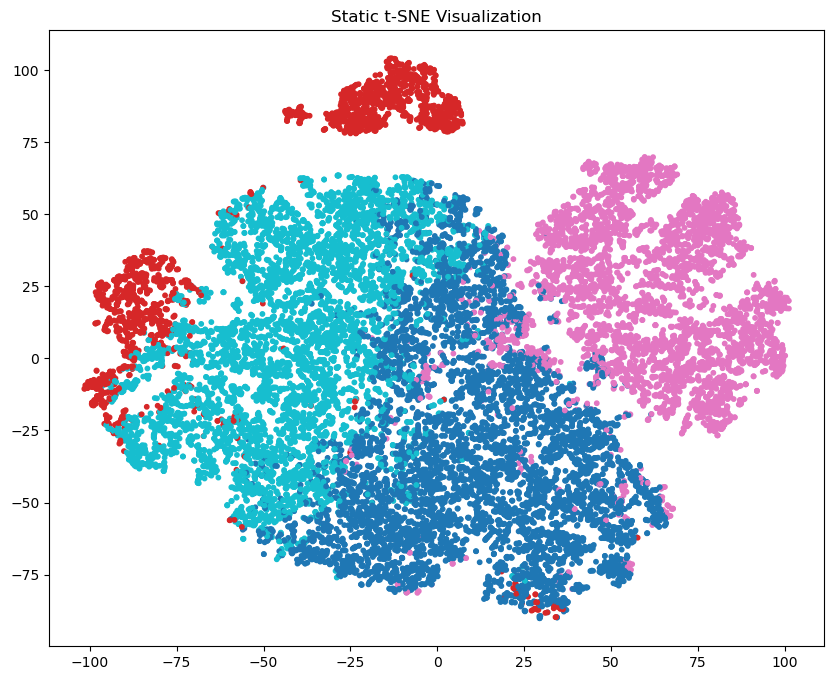

In [4]:
CSV_PATH = os.path.join(RESULTS_DIR, "clustering_results.csv")
PCA_PATH = os.path.join(RESULTS_DIR, "X_pca.npy")
PNG_PATH = os.path.join(RESULTS_DIR, "tsne_static.png")

# Compute t-SNE and update the CSV with 'tsne_1' and 'tsne_2' columns
visualization.compute_and_save_tsne(CSV_PATH, PCA_PATH, PNG_PATH)

## Step 4: Interactive Exploration

The final step launches an interactive window. Clicking on a point in the t-SNE plot opens the specific boat's chip and its global satellite context simultaneously.

In [6]:
# Enable interactive windows
%matplotlib qt 

# Ensure the paths are correct for the Notebook's root location
FINAL_CSV = os.path.join(RESULTS_DIR, "clustering_results.csv")
# We need to tell the class where the raw TIFFs are
interactive.RAW_DATA_DIR = "./data/raw" 

if os.path.exists(FINAL_CSV):
    # Initialize the app
    # We close any existing plots to prevent event loop conflicts
    plt.close('all') 
    app = interactive.UltimateInteractivePlot(FINAL_CSV)
    plt.show()
else:
    print(f"Error: {FINAL_CSV} not found. Please run the Clustering and Visualization cells first.")

Plotting 21595 boats...
